## kEffNet-B0 version 1 with CIFAR-10, CIFAR-100, MNIST or FASHION MNIST.
You can learn more about these datasets at:
* CIFAR-10 and CIFAR-100: https://www.cs.toronto.edu/~kriz/cifar.html .
* MNIST: http://yann.lecun.com/exdb/mnist/ .
* FASHION MNIST: https://github.com/zalandoresearch/fashion-mnist .

This example is part of the [K-CAI Neural API](https://github.com/joaopauloschuler/k-neural-api).

You might need to install this on your system:

apt-get install python3-opencv git

In [ ]:
#@title Global Settings
from tensorflow import keras
import tensorflow.keras.layers
import tensorflow.keras.models
import tensorflow.keras.datasets
from tensorflow.keras import regularizers
dataset=tensorflow.keras.datasets.cifar10 #@param ["tensorflow.keras.datasets.cifar10", "tensorflow.keras.datasets.cifar100", "tensorflow.keras.datasets.mnist", "tensorflow.keras.datasets.fashion_mnist"] {type:"raw"} 
batch_size=64 # @param [16, 32, 64, 128, 256, 512] {type:"raw"} 
min_channels_per_group=16 # @param [16, 32] {type:"raw"}
epochs=50 # @param [2, 50, 100, 100, 200, 400] {type:"raw"}
verbose=True #@param {type:"boolean"}
bipolar_input=True #@param {type:"boolean"}
seed=7

if dataset is keras.datasets.cifar10 or dataset is keras.datasets.cifar100:
  global_input_shape = (32, 32, 3)
else:
  global_input_shape = (28, 28, 1)

if (dataset==keras.datasets.cifar100):
  num_classes = 100
else:
  num_classes = 10

In [ ]:
import os
if not os.path.isdir('k'):
 !git clone -b development14 https://github.com/joaopauloschuler/k-neural-api.git k
else:
 !cd k && git pull
!cd k && pip install .

Already up to date.
Processing /content/k
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for cai: filename=cai-0.1.5-py3-none-any.whl size=57413 sha256=06991e5e45c35e8729dc976a05ec731be0f5113660f1e27d0353e1cc1a2f72de
  Stored in directory: /tmp/pip-ephem-wheel-cache-6l_01hvk/wheels/c1/8a/57/56dbba25eff58e52e5365435c4fa102ad8d6f9787d3b4db13a
Successfully built cai
  Attempting uninstall: cai
    Found existing installation: cai 0.1.5
    Uninstalling cai-0.1.5:
      Successfully uninstalled cai-0.1.5


In [ ]:
import cai.layers
import cai.datasets
import cai.efficientnet
import cai.util
from tensorflow.keras import mixed_precision
import gc
import multiprocessing
import random
import tensorflow as tf
import numpy as np
print("Tensorflow version:", tf.version.VERSION)
print("Keras version:", keras.__version__)
print("CPU cores:", multiprocessing.cpu_count())
import psutil
print('RAM:', (psutil.virtual_memory().total / 1e9),'GB')
print(tf.config.list_physical_devices('GPU'))
import matplotlib.pylab as plt
from sklearn.metrics import classification_report

Tensorflow version: 2.7.0
Keras version: 2.7.0
CPU cores: 2
RAM: 13.62219008 GB
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
if min_channels_per_group==16:
   kTypes = [cai.layers.D6_16ch()]
else:
   kTypes = [cai.layers.D6_32ch()]

In [ ]:
!nvidia-smi

Thu Dec 23 09:03:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-SXM2-16GB, compute capability 7.0


In [ ]:
base_model_name='kEffNetV1Example'
x_train, y_train, x_test, y_test = cai.datasets.load_dataset(dataset, verbose=verbose, lab=False, bipolar=bipolar_input, base_model_name=base_model_name)
print(x_train.shape)
print(y_train.shape)

train shape (50000, 32, 32, 3)
test shape (10000, 32, 32, 3)
Original channel  0  min: 0.0  max: 255.0
Original channel  1  min: 0.0  max: 255.0
Original channel  2  min: 0.0  max: 255.0
Loading RGB.
Channel  0  min: -2.0  max: 1.984375
Channel  1  min: -2.0  max: 1.984375
Channel  2  min: -2.0  max: 1.984375
(50000, 32, 32, 3)
(50000, 10)


In [ ]:
train_datagen = cai.util.create_image_generator(validation_split=0.04, rotation_range=20, width_shift_range=0.3, height_shift_range=0.3, channel_shift_range=0.0)
test_datagen = cai.util.create_image_generator_no_augmentation()
cpus_num = max([multiprocessing.cpu_count(), 8])

def cyclical_adv_lrscheduler25(epoch):
    """CAI Cyclical and Advanced Learning Rate Scheduler.
    # Arguments
        epoch: integer with current epoch count.
    # Returns
        float with desired learning rate.
    """
    base_learning = 0.001
    local_epoch = epoch % 25
    if local_epoch < 7:
       return base_learning * (1 + 0.5*local_epoch)
    else:
       return (base_learning * 4) * ( 0.85**(local_epoch-7) )

In [ ]:
def work_on_efficientnet(show_model=False, run_fit=False, test_results=False, calc_f1=False, kTypes=[]):
  monitor='val_accuracy'
  if (calc_f1): 
    test_results=True
  if (show_model):
    input_shape = global_input_shape
  else:
    input_shape = (None, None, global_input_shape[2])
  for kType in kTypes:
      basefilename = 'kEffNetV1-'+str(kType)
      best_result_file_name = basefilename+'-best_result.hdf5'
      print('Running: '+basefilename)
      model = cai.efficientnet.kEfficientNetB0(
        include_top=True,
        skip_stride_cnt=3,
        input_shape=input_shape,
        classes=num_classes,
        kType=kType)
      
      optimizer = keras.optimizers.RMSprop()
      optimizer = mixed_precision.LossScaleOptimizer(optimizer)
      model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

      if (show_model): 
        model.summary(line_length=180)

      save_best = keras.callbacks.ModelCheckpoint(
            filepath=best_result_file_name,
            monitor=monitor,
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode='max',
            save_freq='epoch')

      if (run_fit): 
            train_flow = train_datagen.flow(
                x_train, y_train,
                batch_size=batch_size,
                shuffle=True,
                seed=seed,
                subset='training'
            )
            validation_flow = train_datagen.flow(
                x_train, y_train,
                batch_size=batch_size,
                shuffle=True,
                seed=seed,
                subset='validation'
            )
            history = model.fit(
              x = train_flow,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=validation_flow,
              callbacks=[save_best, tf.keras.callbacks.LearningRateScheduler(cyclical_adv_lrscheduler25)],
              workers=cpus_num,
              max_queue_size=128
            )
            plt.figure()
            plt.ylabel("Accuracy (training and validation)")
            plt.xlabel("Epochs")
            plt.ylim([0,1])
            plt.plot(history.history["accuracy"])
            plt.plot(history.history["val_accuracy"])
      if (test_results):
        test_flow = test_datagen.flow(
            x_test, y_test,
            batch_size=batch_size,
            shuffle=True,
            seed=seed
        )
        print('Best Model Results: '+best_result_file_name)
        model = cai.models.load_kereas_model(best_result_file_name)
        evaluated = model.evaluate(
            x=test_flow,
            batch_size=batch_size,
            use_multiprocessing=False,
            workers=cpus_num
        )
        for metric, name in zip(evaluated,["loss","acc"]):
              print(name,metric)
      if (calc_f1):
        model = cai.models.load_kereas_model(best_result_file_name)
        pred_y = model.predict(x_test)
        print("Predicted Shape:", pred_y.shape)
        pred_classes_y = np.array(list(np.argmax(pred_y, axis=1)))
        test_classes_y = np.array(list(np.argmax(y_test, axis=1)))
        print("Pred classes shape:",pred_classes_y.shape)
        print("Test classes shape:",test_classes_y.shape)
        report = classification_report(test_classes_y, pred_classes_y, digits=4)
        print(report)
      print('Finished: '+basefilename)

# Show the model

In [ ]:
work_on_efficientnet(show_model=True, run_fit=False, test_results=False, kTypes=kTypes)

Running: kEffNetV1-2
Model: "kEffNet-b0"
____________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                              Output Shape                            Param #              Connected to                                                
 input_1 (InputLayer)                                      [(None, 32, 32, 3)]                     0                    []                                                          
                                                                                                                                                                                    
 k_stem_conv_pad (ZeroPadding2D)                           (None, 33, 33, 3)                       0                    ['input_1[0][0]']                                           
                                                      

#Fitting

Running: kEffNetV1-2
Epoch 1/50
750/750 [==============================] - ETA: 0s - loss: 2.3120 - accuracy: 0.2294
Epoch 00001: val_accuracy improved from -inf to 0.30250, saving model to kEffNetV1-2-best_result.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


750/750 [==============================] - 327s 337ms/step - loss: 2.3120 - accuracy: 0.2294 - val_loss: 1.9716 - val_accuracy: 0.3025 - lr: 0.0010
Epoch 2/50
750/750 [==============================] - ETA: 0s - loss: 1.8161 - accuracy: 0.3359
Epoch 00002: val_accuracy improved from 0.30250 to 0.33150, saving model to kEffNetV1-2-best_result.hdf5
750/750 [==============================] - 238s 317ms/step - loss: 1.8161 - accuracy: 0.3359 - val_loss: 2.0848 - val_accuracy: 0.3315 - lr: 0.0015
Epoch 3/50
750/750 [==============================] - ETA: 0s - loss: 1.5186 - accuracy: 0.4521
Epoch 00003: val_accuracy improved from 0.33150 to 0.53250, saving model to kEffNetV1-2-best_result.hdf5
750/750 [==============================] - 238s 317ms/step - loss: 1.5186 - accuracy: 0.4521 - val_loss: 1.3560 - val_accuracy: 0.5325 - lr: 0.0020
Epoch 4/50
750/750 [==============================] - ETA: 0s - loss: 1.2955 - accuracy: 0.5371
Epoch 00004: val_accuracy improved from 0.53250 to 0.56650

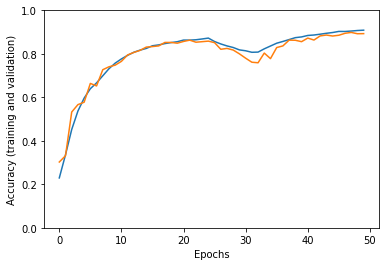

In [ ]:
work_on_efficientnet(show_model=False, run_fit=True, test_results=False, kTypes=kTypes)

#Test the result

In [ ]:
work_on_efficientnet(show_model=False, run_fit=False, test_results=True, kTypes=kTypes)

Running: kEffNetV1-2
Best Model Results: kEffNetV1-2-best_result.hdf5
157/157 [==============================] - 23s 72ms/step - loss: 0.2281 - accuracy: 0.9258
loss 0.2281276434659958
acc 0.9258000254631042
Finished: kEffNetV1-2


# Calculate F1

In [ ]:
work_on_efficientnet(show_model=False, run_fit=False, test_results=False, calc_f1=True, kTypes=kTypes)

Running: kEffNetV1-2
Best Model Results: kEffNetV1-2-best_result.hdf5
157/157 [==============================] - 23s 72ms/step - loss: 0.2281 - accuracy: 0.9258
loss 0.2281276434659958
acc 0.9258000254631042
Predicted Shape: (10000, 10)
Pred classes shape: (10000,)
Test classes shape: (10000,)
              precision    recall  f1-score   support

           0     0.9204    0.9480    0.9340      1000
           1     0.9529    0.9720    0.9624      1000
           2     0.9088    0.8970    0.9029      1000
           3     0.8779    0.8410    0.8590      1000
           4     0.9213    0.9360    0.9286      1000
           5     0.9246    0.8460    0.8836      1000
           6     0.8917    0.9720    0.9301      1000
           7     0.9461    0.9480    0.9471      1000
           8     0.9595    0.9470    0.9532      1000
           9     0.9558    0.9510    0.9534      1000

    accuracy                         0.9258     10000
   macro avg     0.9259    0.9258    0.9254     10000
w